In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as img
import os

import re

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

import warnings
warnings.filterwarnings(action='ignore')

# 폴더 만들기

In [4]:
image_path = '/content/drive/MyDrive/23-1 CV프로젝트 1팀/waifu/' # 해상도 높인 이미지 들어있는 폴더
image_list = os.listdir(image_path)
save_path = '/content/drive/MyDrive/23-1 CV프로젝트 1팀/anime_sort/' # 저장 폴더 지정
save_list = os.listdir(save_path)

In [ ]:
my_list = []

for file in image_list:
  if file not in save_list:
    my_list.append(file)

my_list

['연우의 순정',
 '자매전쟁',
 '순정말고 순종',
 '뮤즈 온 유명',
 '세레나',
 '손 안의 안단테',
 '노답소녀',
 '여우놀이',
 '내가 죽기로 결심한 것은',
 '나를 바꿔줘',
 '별을 삼킨 너에게',
 '반드시 해피엔딩',
 '모노마니아',
 '가짜 동맹',
 '작전명 순정',
 '대충 캠퍼스로맨스임',
 '유사연애',
 '그렇고 그런 바람에']

In [ ]:
# # save path에 폴더 생성(할 필요 없음, 한 폴더에 다 저장하는 게 나음)

# for webtoon in my_list:
#   os.mkdir(os.path.join(save_path,  webtoon))

### VGG16으로 feature vector 추출

In [6]:
class FeatureExtractor:
  def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

  def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = img
        x = np.expand_dims(x, axis=0) #차원추가
        x = preprocess_input(x) #모델에 필요한 형식에 이미지를 적절하게 맞추기위한 것
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

### 코사인 유사도 기반 비교

In [7]:
# 코사인유사도 계산 함수
def cos(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [8]:
fe = FeatureExtractor()

553467096/553467096 [==============================] - 3s 0us/step


In [9]:
cnt = 0
for webtoon in my_list:
  read_path = image_path + webtoon + '/'
  final_path = save_path + webtoon + '/'

  my_file = os.listdir(read_path)

  print("---------------" + webtoon + " 시작!---------------")

  images = [0 for i in range(len(my_file))]
  features_vgg = [0 for i in range(len(my_file))]

  i = 0
  for file_name in my_file:
    path = read_path + file_name
    img = Image.open(path)
    fea = fe.extract(img)
    features_vgg[i] = fea
    images[i] = img
    i = i + 1

  char = Image.open('/content/drive/MyDrive/23-1 CV프로젝트 1팀/main_char/' + webtoon + '.jpg') # 비교할 주인공 이미지 들어있는 폴더 + 주인공 이미지 이름은 웹툰명으로 저장

  fea_char = fe.extract(char)
  features_char_vgg = fea_char

  images_resize = [0 for i in range(len(images))]

  for i in range(len(images)):
    images_resize[i] = images[i].resize((512, 512)).convert('RGB')

  char_resize = char.resize((512, 512)).convert('RGB')

  images_array = [np.array(i) for i in images_resize]

  dist_2 = []
  for i in range(len(features_vgg)):
    dist= cos(features_char_vgg, features_vgg[i])
    dist_2.append((dist,i))

  b = sorted(dist_2, reverse=True)

  sim = [b[i][0] for i in range(len(b))]

  index_b = [b[i][1] for i in range(len(b))]

  for i in range(100):
    img = images[index_b[i]]
    img.save(save_path + "webtoon" + str(cnt) + '_' + str(i) + ".jpg")

  print("---------------" + webtoon + " 끝!---------------")
  cnt = cnt + 1

---------------작전명 순정 시작!---------------
1/1 [==============================] - 1s 561ms/step
---------------작전명 순정 끝!---------------


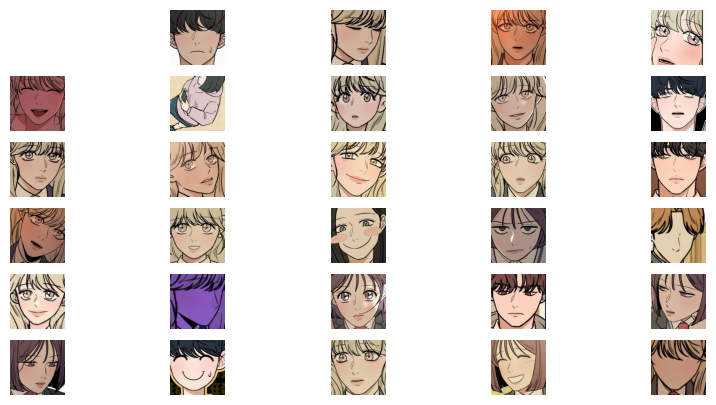

In [12]:
# 상위 30개 이미지 확인

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(char_resize)
plt.axis('off')

for i in range(29):
  plt.subplot(6,5,i+2)
  plt.imshow(images[index_b[i]])
  plt.axis('off')

# 다른 시도

## RESNET18

In [ ]:
# # Load the pretrained model
# model = models.resnet18(pretrained=True)

# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')

# # Set model to evaluation mode
# model.eval()

# # Image transforms
# scaler = transforms.Resize((224, 224))
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# to_tensor = transforms.ToTensor()

# def get_vector(image_name):
#     # 1. Load the image with Pillow library
#     img = Image.open(image_name)
#     img = img.convert('RGB')
#     # 2. Create a PyTorch Variable with the transformed image
#     t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
#     # 3. Create a vector of zeros that will hold our feature vector
#     #    The 'avgpool' layer has an output size of 512
#     my_embedding = torch.zeros([1, 512, 1, 512])
#     # 4. Define a function that will copy the output of a layer
#     def copy_data(m, i, o):
#         my_embedding.copy_(o.data)
#     # 5. Attach that function to our selected layer
#     h = layer.register_forward_hook(copy_data)
#     # 6. Run the model on our transformed image
#     model(t_img)
#     # 7. Detach our copy function from the layer
#     h.remove()
#     # 8. Return the feature vector
#     return my_embedding

In [ ]:
# def cos_pytorch(A, B):
#   cos= nn.CosineSimilarity(dim=1, eps=1e-6)
#   cos_sim = cos(A, B)
#   return cos_sim.numpy()[0][0][0]

In [ ]:
# fea_char_res = get_vector("/content/drive/MyDrive/23-1 CV프로젝트 1팀/anime_sort/뮤즈온유명/해상도/cropped_image0.jpg")
# features_char_resnet = fea_char_res

In [ ]:
# features_resnet = [0 for i in range(len(images))]
# for i in range(len(images)):
#   if os.path.exists("/content/drive/MyDrive/23-1 CV프로젝트 1팀/anime_sort/뮤즈온유명/해상도/cropped_image{i}.jpg"):
#     fea_res = get_vector(f"/content/drive/MyDrive/23-1 CV프로젝트 1팀/anime_sort/뮤즈온유명/해상도/cropped_image{i}.jpg")
#     features_resnet[i] = fea_res

## 1. 유클리디안 거리 기반 추천

In [ ]:
images_resize = [0 for i in range(len(images))]

for i in range(len(images)):
  images_resize[i] = images[i].resize((512, 512)).convert('RGB')

char_resize = char.resize((512, 512)).convert('RGB')

images_array = [np.array(i) for i in images_resize]

In [ ]:
images_array = [np.array(i) for i in images_resize]

In [ ]:
# dist_1 = []
# for i in range(len(images_array)):
#   dis = np.linalg.norm(char_resize - images_array[i]) #0번째 사진에 대한 추천
#   dist_1.append((dis,i))

In [ ]:
# c = sorted(dist_1)

In [ ]:
# print(c) #거리와 유사 아이템 인덱스

[(0.0, 134), (100570.02781644241, 62), (101556.02655677308, 153), (103304.58190709645, 252), (103399.63581173775, 228), (105426.06245611186, 166), (105547.90765334952, 159), (105982.47991059655, 259), (106424.9657881082, 150), (106503.93384283982, 261), (106571.22432908426, 205), (108131.44132952265, 193), (108912.50634798559, 280), (108973.21859062437, 154), (110043.17395004563, 229), (110155.2766643523, 37), (111304.41134115035, 184), (111759.11862125613, 27), (111767.7667308424, 262), (112137.85491973707, 74), (113961.10437776566, 168), (115238.9603693126, 279), (115763.81911892851, 33), (116300.14195606126, 240), (118301.8504335414, 186), (118718.96423065693, 167), (120002.77015969256, 230), (120025.38170737054, 138), (121027.08007714637, 42), (121481.66834135923, 183), (121939.30014150483, 131), (123015.78293454868, 172), (123277.0973822794, 201), (124167.84197609298, 132), (125076.60612600583, 103), (125087.83505601174, 46), (125364.89694089012, 195), (125798.3860230329, 175), (1

In [ ]:
# index_c = [c[i][1] for i in range(len(c))]

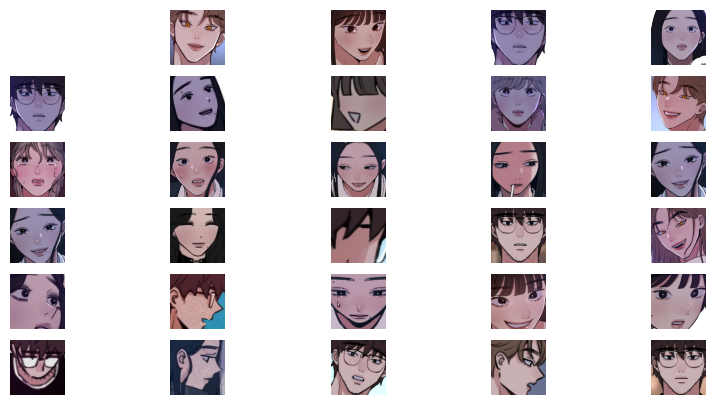

In [ ]:
# plt.figure(figsize = (10,5))

# plt.subplot(2,5,1)
# plt.imshow(char_resize)
# plt.axis('off')

# for i in range(29):
#   plt.subplot(6,5,i+2)
#   plt.imshow(images[index_c[i]])
#   plt.axis('off')

## 2. VGG16으로 추출한 feature vector 간 cosine similarity 기반 추천

In [ ]:
dist_2 = []
for i in range(len(features_vgg)):
  dist= cos(features_char_vgg, features_vgg[i])
  dist_2.append((dist,i))

b = sorted(dist_2, reverse=True)

sim = [b[i][0] for i in range(len(b))]

index_b = [b[i][1] for i in range(len(b))]

In [ ]:
b = sorted(dist_2, reverse=True)
# b = sorted(dist_2)

In [ ]:
sim = [b[i][0] for i in range(len(b))]
print(sim)

[1.0, 0.99999475, 0.87584764, 0.87584764, 0.87551457, 0.8660982, 0.8660982, 0.8660443, 0.83636045, 0.8354135, 0.83521444, 0.83521444, 0.79726124, 0.79726124, 0.79338765, 0.79338765, 0.7932812, 0.7745277, 0.77446383, 0.7744612, 0.7744612, 0.7701011, 0.7701011, 0.75965995, 0.75115025, 0.7510436, 0.7510436, 0.73562115, 0.73562115, 0.73552656, 0.7305825, 0.7305825, 0.72993815, 0.7297081, 0.71806985, 0.71780074, 0.71534854, 0.714833, 0.714833, 0.71373004, 0.71373004, 0.7128992, 0.68234754, 0.68234754, 0.6626471, 0.6626471, 0.6440277, 0.6394426, 0.6394426, 0.63698316, 0.63698316, 0.6369664, 0.6357117, 0.6355559, 0.6238076, 0.6236588, 0.62199, 0.6207859, 0.6204201, 0.6189648, 0.618783, 0.6095566, 0.60953104, 0.60587317, 0.6056365, 0.60378057, 0.60342276, 0.6011376, 0.6011125, 0.60061485, 0.59826505, 0.5958313, 0.59583026, 0.5918214, 0.59024847, 0.59023887, 0.5896063, 0.5893901, 0.58932805, 0.58925104, 0.58922064, 0.58898425, 0.58898425, 0.5889781, 0.5889098, 0.5889098, 0.588331, 0.58637923, 0

In [ ]:
print(b) #resnet

[(1.0, 285), (0.99999475, 0), (0.87584764, 296), (0.87584764, 270), (0.87551457, 67), (0.8660982, 277), (0.8660982, 250), (0.8660443, 9), (0.83636045, 314), (0.8354135, 52), (0.83521444, 274), (0.83521444, 258), (0.79726124, 281), (0.79726124, 259), (0.79338765, 304), (0.79338765, 264), (0.7932812, 63), (0.7745277, 181), (0.77446383, 310), (0.7744612, 278), (0.7744612, 252), (0.7701011, 283), (0.7701011, 267), (0.75965995, 288), (0.75115025, 77), (0.7510436, 279), (0.7510436, 251), (0.73562115, 276), (0.73562115, 260), (0.73552656, 15), (0.7305825, 284), (0.7305825, 265), (0.72993815, 297), (0.7297081, 156), (0.71806985, 79), (0.71780074, 295), (0.71534854, 1), (0.714833, 306), (0.714833, 262), (0.71373004, 298), (0.71373004, 261), (0.7128992, 36), (0.68234754, 287), (0.68234754, 253), (0.6626471, 292), (0.6626471, 254), (0.6440277, 275), (0.6394426, 290), (0.6394426, 231), (0.63698316, 322), (0.63698316, 222), (0.6369664, 188), (0.6357117, 273), (0.6355559, 106), (0.6238076, 20), (0.6

In [ ]:
index_b = [b[i][1] for i in range(len(b))]

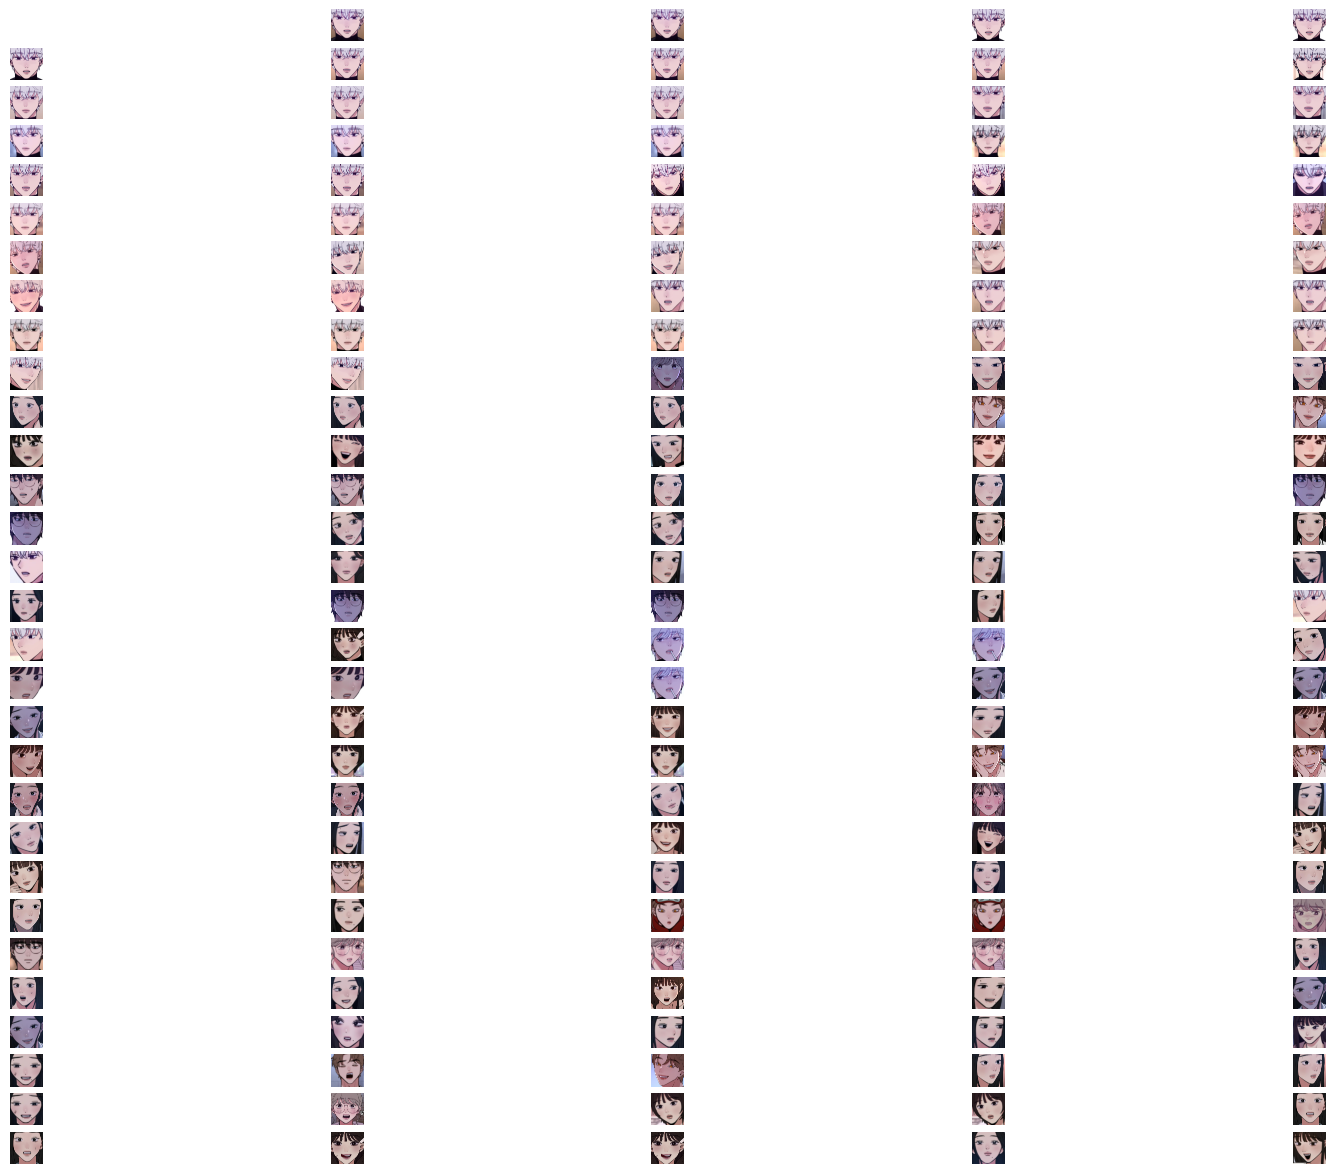

In [ ]:
plt.figure(figsize = (20,15))

plt.subplot(2,5,1)
plt.imshow(char_resize)
plt.axis('off')

for i in range(149):
  plt.subplot(30, 5, i+2)
  plt.imshow(images[index_b[i]])
  plt.axis('off')